# Gaussian Processes

This article demonstrates the how to use Bambi with Gaussian Processes with 1 dimensional predictors. Bambi supports Gaussian Processes through the approximation known as Hilbert Space Gaussian Processes (HSGP). 

HSGP is a framework that falls under the class of low-rank approximations that are based on forming a basis function approximation with $m$ basis functions, where $m$ is usually much less smaller than $n$, the number of observations.

For references see [Hilbert Space Methods for Reduced-Rank Gaussian Process Regression](https://arxiv.org/abs/1401.5508) and [Practical Hilbert Space Approximate Bayesian Gaussian Processes for Probabilistic Programming](https://arxiv.org/abs/2004.11408).

If you prefer a video format, have a look at [Introduction to Hilbert Space GPs in PyMC](https://www.youtube.com/watch?v=ri5sJAdcYHk&ab_channel=PyMCDevelopers) given by Bill Engels.

In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.interpret import plot_predictions
from matplotlib.lines import Line2D

## A basic example

Let's get started simulating some data from a smooth function. The goal is to fit a normal likelihood model where a Gaussian process term contributes to the mean.

/tmp/ipykernel_67987/643498689.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X = np.array(dm.common)


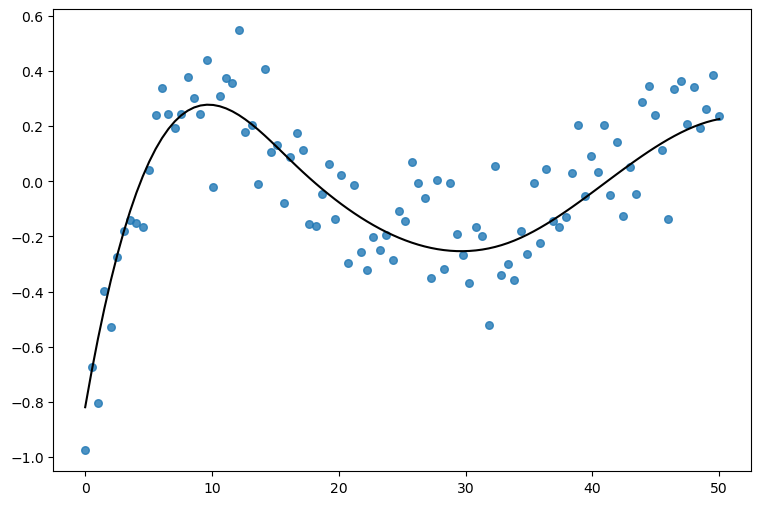

In [2]:
rng = np.random.default_rng(seed=121195)

size = 100
x = np.linspace(0, 50, size)
b = 0.1 * rng.normal(size=6)
sigma = 0.15

dm = design_matrices("0 + bs(x, df=6, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + rng.normal(size=size) * sigma
df = pd.DataFrame({"x": x, "y": y})

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

Now let's simply create and fit the model. We use the `hsgp` to initialize a HSGP term in the model formula. Notice we pass the variable `x` and values for two other arguments `m` and `c` that we'll cover later.

In [3]:
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2)", df)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.2745)

In the model description we can see the contribution of the HSGP term. It consists of two things: the name of the covariance kernel and the priors for its parameters. In this case, it's an **Exp**onentiated **Quad**ratic covariance kernel with parameters `sigma` (amplitude) and `ell` (lengthscale). The prior for the amplitude is `Exponential(1)` and the prior for the lengthscale is `InverseGamma(3, 2)`.

In [4]:
idata = model.fit(random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp(x, m=10, c=2)_sigma, hsgp(x, m=10, c=2)_ell, hsgp(x, m=10, c=2)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 896 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


896


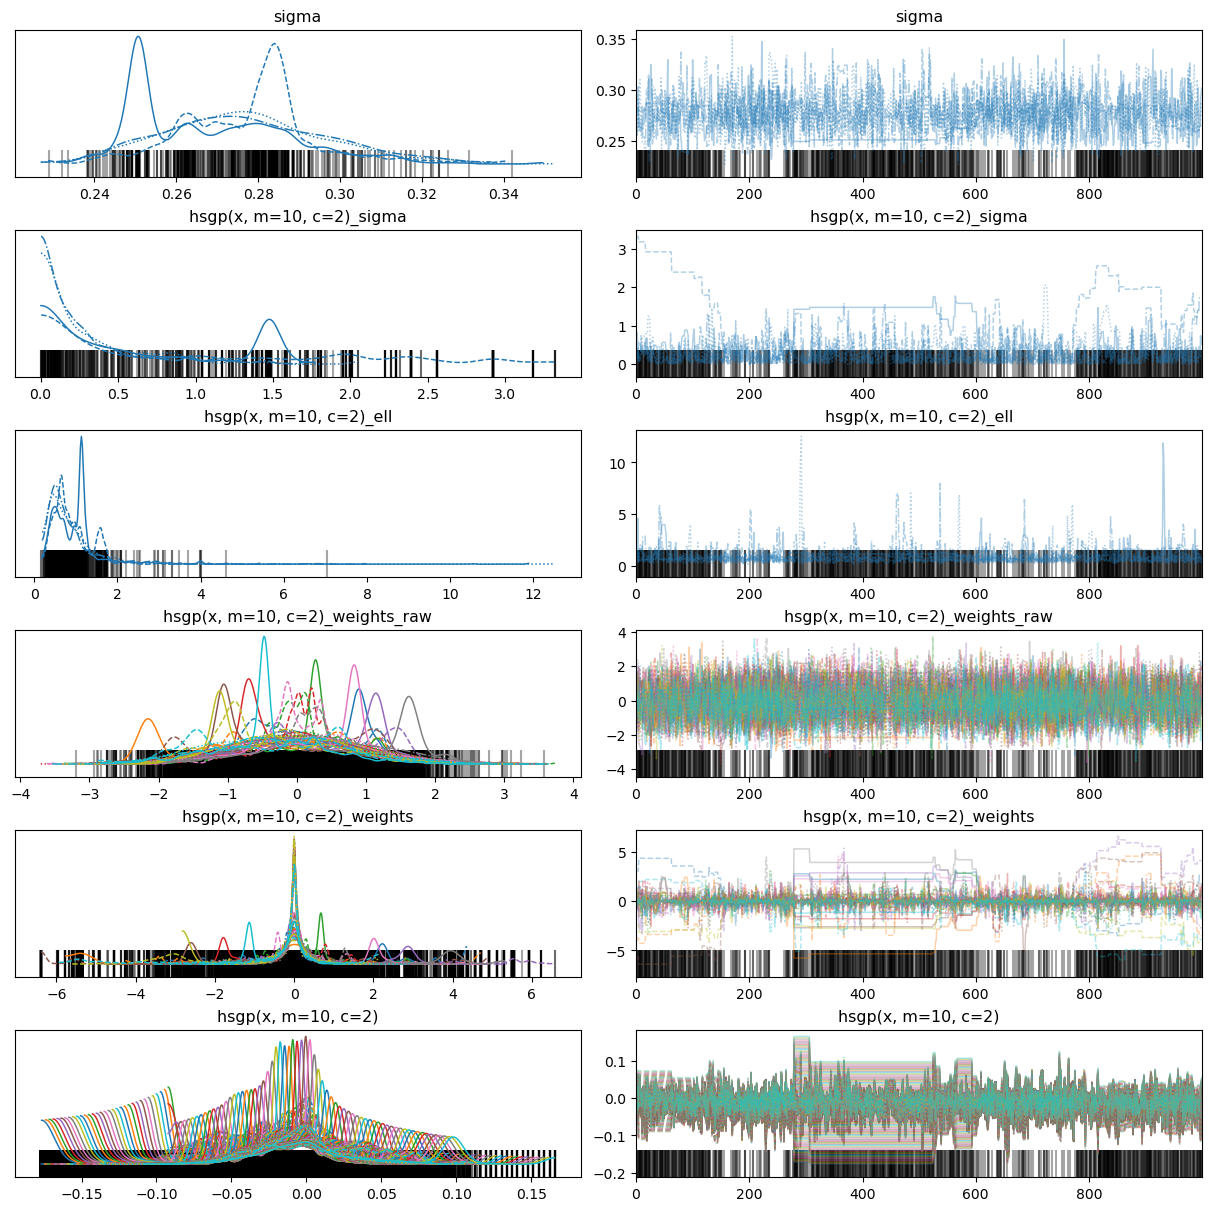

In [5]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

The fit is horrible. To fix that we can use better priors. But before doing that, it's important to note that HSGP terms have a unique characteristic in that they do not receive priors themselves. Rather, the associated parameters of an HSGP term, such as `sigma` and `ell`, are the ones that are assigned priors. Therefore, we need to assign the HSGP term a dictionary of priors instead of a single prior. 

In [6]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2), # amplitude
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1) # lengthscale
}

# This is the dictionary we pass to Bambi
priors = {
    "hsgp(x, m=10, c=2)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2)", df, priors=priors)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2)
                cov: ExpQuad
                sigma ~ Exponential(lam: 2.0)
                ell ~ InverseGamma(mu: 10.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

Notice the priors were updated in the model summary. Now we're ready to fit the model!

In [7]:
idata = model.fit(random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp(x, m=10, c=2)_sigma, hsgp(x, m=10, c=2)_ell, hsgp(x, m=10, c=2)_weights_raw]


Output()

/home/tomas/Desktop/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.


47


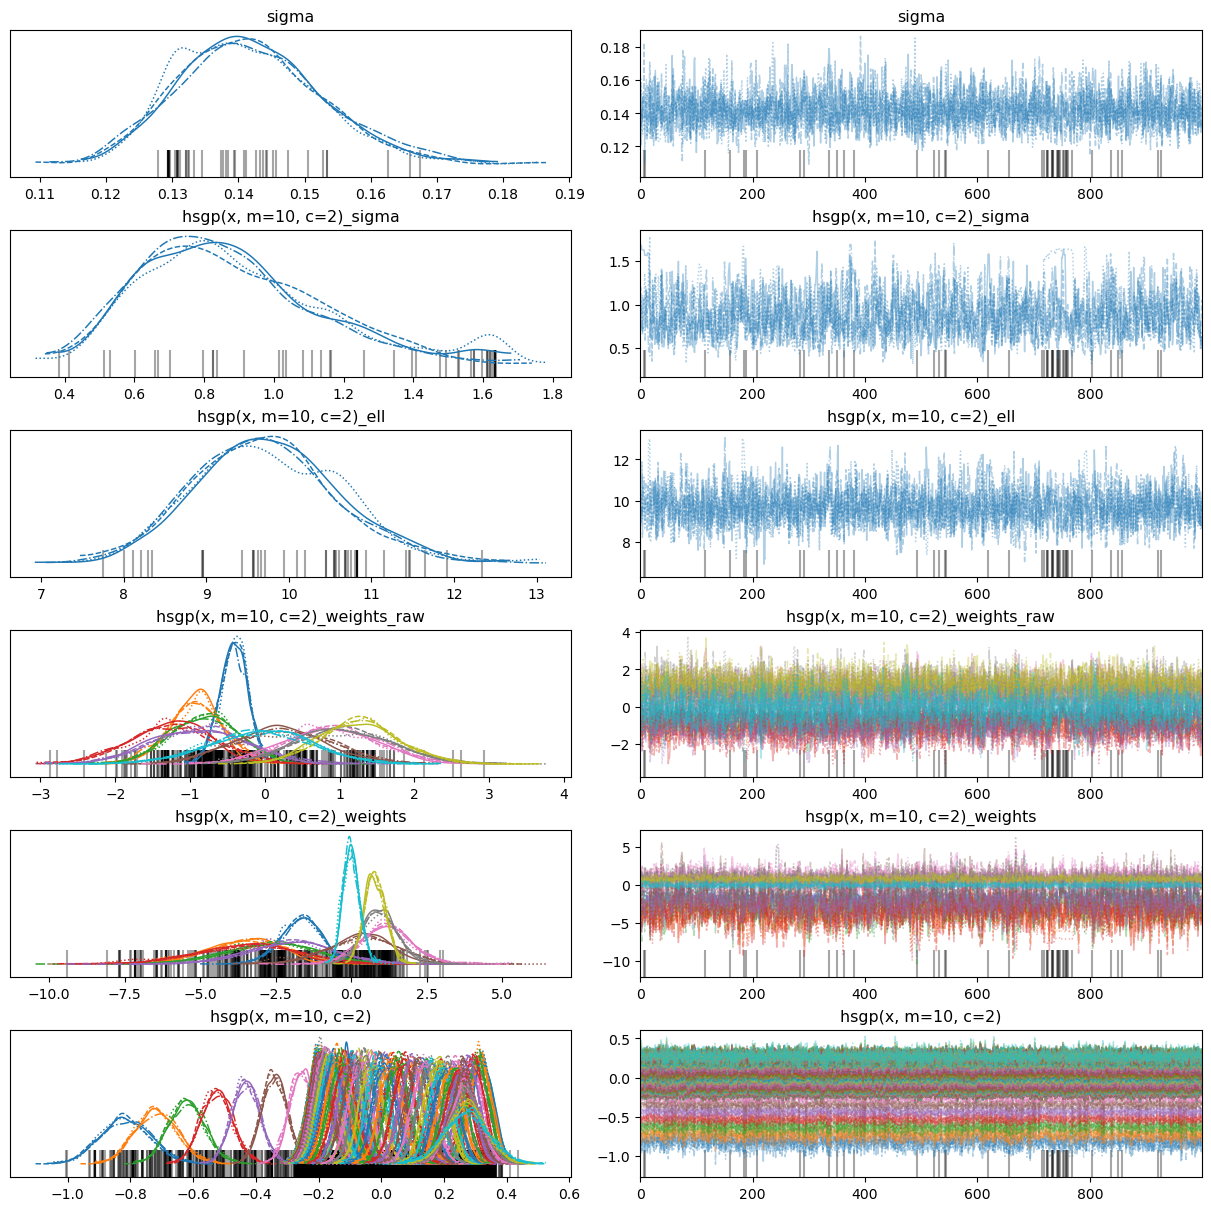

In [8]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

The marginal posteriors look somehow better, but we still have lots of divergences. What else can we do? Change the parametrization!

The `hsgp()` function has a `centered` argument which defaults to `False` and thus Bambi uses a non-centered parametrization by default. But we can change that actually. Let's try it!

In [9]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2), # amplitude
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1) # lengthscale
}

# This is the dictionary we pass to Bambi
priors = {
    "hsgp(x, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2, centered=True)", df, priors=priors)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2, centered=True)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2, centered=True)
                cov: ExpQuad
                sigma ~ Exponential(lam: 2.0)
                ell ~ InverseGamma(mu: 10.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

In [10]:
idata = model.fit(random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp(x, m=10, c=2, centered=True)_sigma, hsgp(x, m=10, c=2, centered=True)_ell, hsgp(x, m=10, c=2, centered=True)_weights]


Output()

/home/tomas/Desktop/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


0


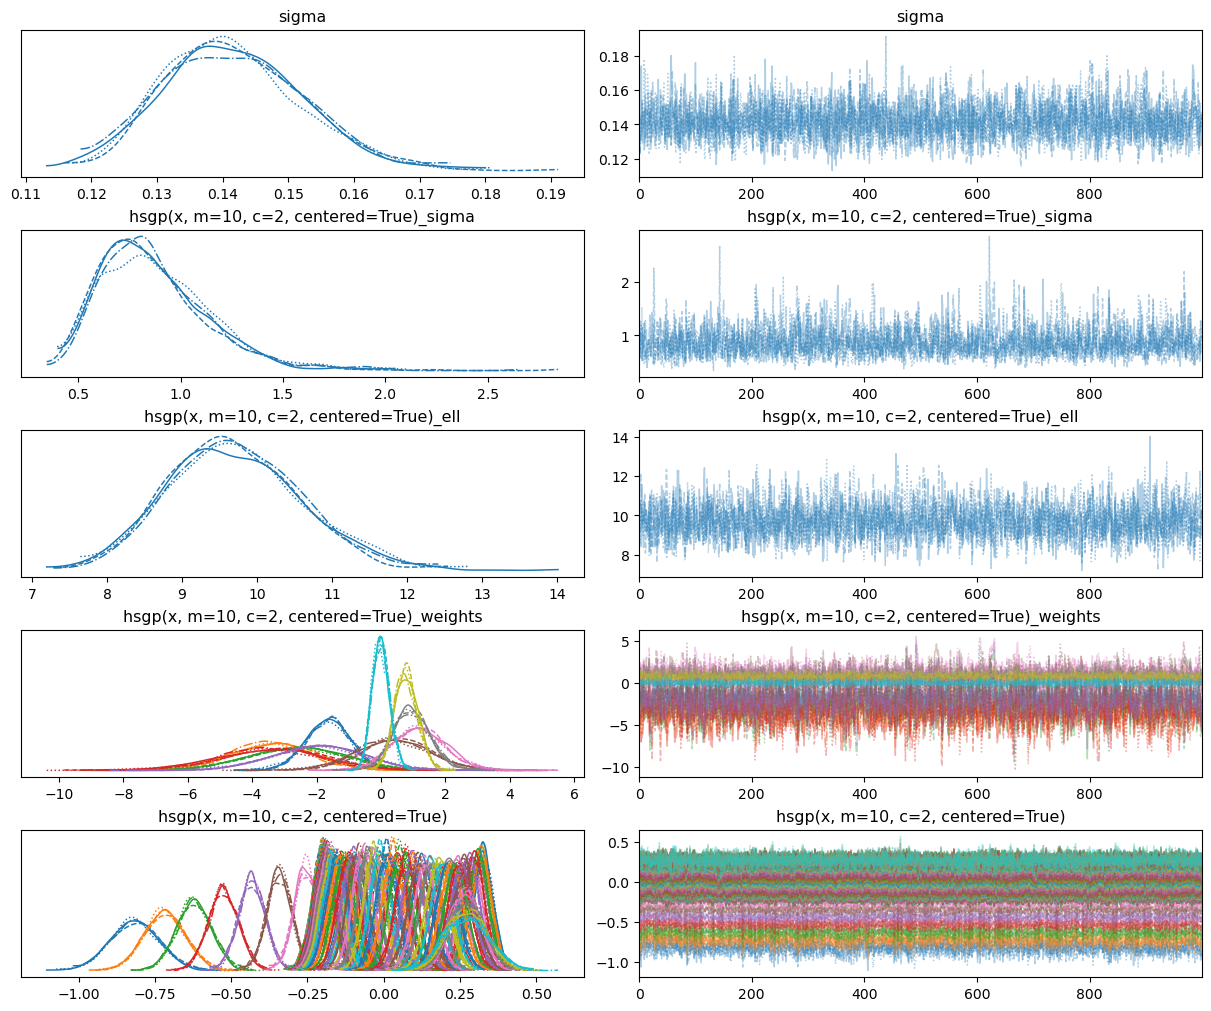

In [11]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

Awesome! That looks much better now.

We still get all the nice things from Bambi when using GPs. An example of this is the `plot_predictions` function from the `interpret` module, which enables us to generate a visualization of the adjusted mean with credible bands automatically.

Default computed for conditional variable: x


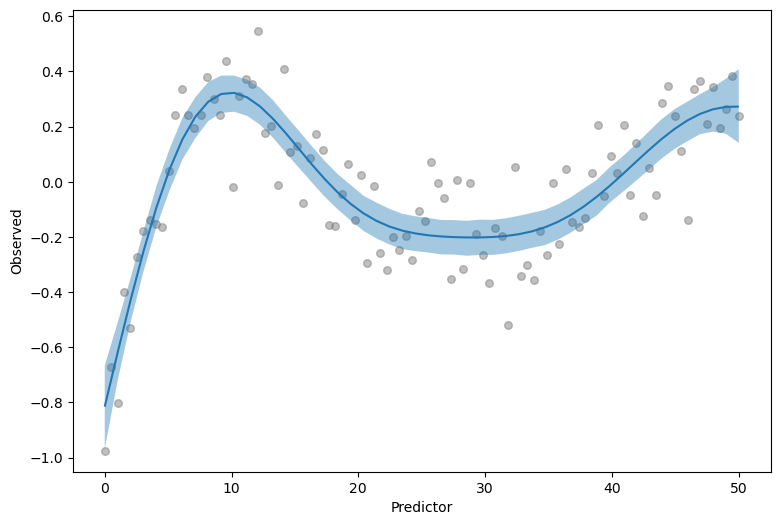

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5)
plot_predictions(model, idata, "x", ax=ax);
ax.set(xlabel="Predictor", ylabel="Observed");

On top of that, we can also get a visualization with intervals of the posterior predictive distribution, for a grid of predictor values.
To get that, we just pass `pps=True` (from posterior predictive samples) to `plot_predictions`.

Default computed for conditional variable: x


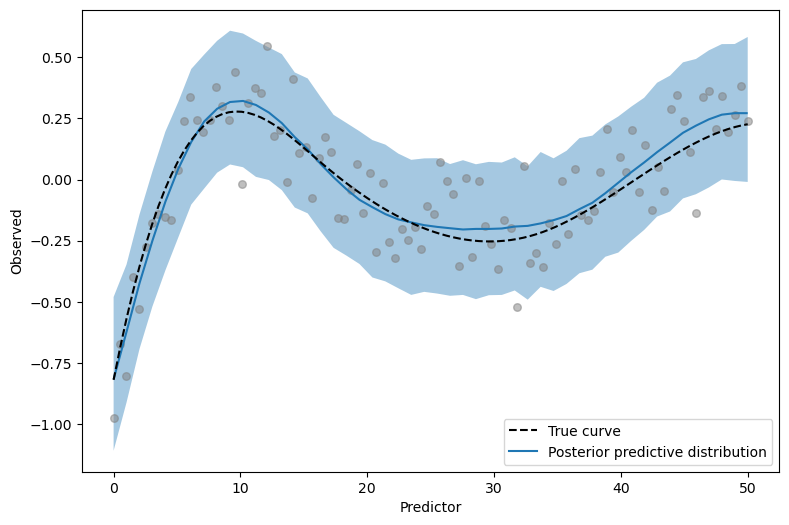

In [13]:
fig, axes = plot_predictions(model, idata, "x", pps=True, fig_kwargs={"figsize": (9, 6)})
ax = axes[0]
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed")

handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ["True curve", "Posterior predictive distribution"]
ax.legend(handles, labels);

## How does `hsgp()` work?

`hsgp()` is a transformation that is available in the namespace where the model formula is evaluated. In plain English, `hsgp()` is like a function you can use in your model formulas. You don't need to worry about the details, Bambi knows how to handle them. But if still you want to see the actual code, you can have a look at the implementation of the `HSGP` class in [bambi/transformations.py](https://github.com/bambinos/bambi/blob/main/bambi/transformations.py).

What users do need to care about is the arguments the `hsgp()` transformation support. There are a bunch of arguments that can be passed after the variable number of non-keyword arguments representing the variables of the HSGP contribution. Below is a brief overview of these arguments and their respective descriptions.

* `m`: The number of basis vectors
* `L`: The boundary of the variable space
* `c`: The proportion extension factor
* `by`: This argument specifies the values of a variable used for grouping. It is used to create a HSGP term by group. If left unspecified, the default value is `None`, which means that there is no group variable and all observations belong to the same group.
* `cov`: This argument specifies the name of the covariance function to be used. The default value is `"ExpQuad"`.
* `share_cov`: Determines whether the same covariance function is shared across all groups. This argument is relevant only when by is not `None` and the default value is `True`. 
* `scale`: When set to `True`, the predictors are be rescaled such that the largest Euclidean distance between two points is 1. This adjustment often improves the sampling speed and convergence. 
* `iso`: Determines whether to use an isotropic or anisotropic (non-isotropic) Gaussian Process. With an isotropic GP, the same level of smoothing is applied to all predictors, while an anisotropic GP allows different levels of smoothing for individual predictors. Note that this argument is ignored if only one predictor is provided. The default value is `True`.
* `drop_first`: Whether to exclude the first basis vector or not. The default value is `False`.
* `centered`: Whether to use the centered or the non-centered parametrization. Defaults to `False`.

The parameters `m`, `L` and `c` are directly related to the basis vectors of the HSGP approximation. If you want to know more about `m`, `L`, and/or `c`, it's recommended to have a look at the documentation of the HSGP class in PyMC.

<!-- **To Do:** Add link -->           

So far, we showcased how to use `m`, `c` and `centered`. In the remainder of this article we're going to see how `by` and `share_cov` are used when we add a GP contribution by groups.

## HSGP by levels of a categorical covariate

In this section we fit a model with a HSGP contribution by levels of a categorical variable. The data was simulated with the `gamSim()` function from the R package `{mgcv}` by Simon Wood.

In [14]:
data = pd.read_csv("data/gam_data.csv")
data["fac"] = pd.Categorical(data["fac"])
data.head()[["x2", "y", "fac"]]

x2         y fac
0  0.497183  3.085274   3
1  0.196003 -2.250410   2
2  0.958474  0.070548   3
3  0.972759 -0.230454   1
4  0.755836  2.173497   2

Let's visualize `x2` versus `y` for the different levels in `fac`. 

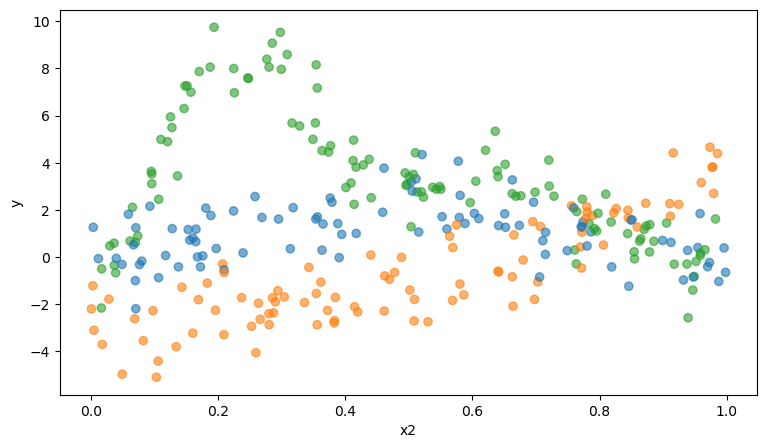

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
ax.set(xlabel="x2", ylabel="y");

We can observe the relation between `x2` and `y` can be approximated by a smooth non-linear curve, for all groups. 

Below, we create the model with Bambi. The biggest difference is that we're passing `by=fac` in the `hsgp()` call. This is all we need to ask Bambi to create multiple GP contribution terms, one per group.

Another trick that was not shown previously is the usage of an alias. `.set_alias()` from the `Model` class allow us to have more readable and shorter names for the components of a model. As you'll see below, it makes a huge difference when displaying summaries or visualizations for the parameters of the model.

In [16]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5)": "hsgp"})
model

       Formula: y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5)
        Family: gaussian
          Link: mu = identity
  Observations: 300
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x2, by=fac, m=12, c=1.5)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ Exponential(lam: 3.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)

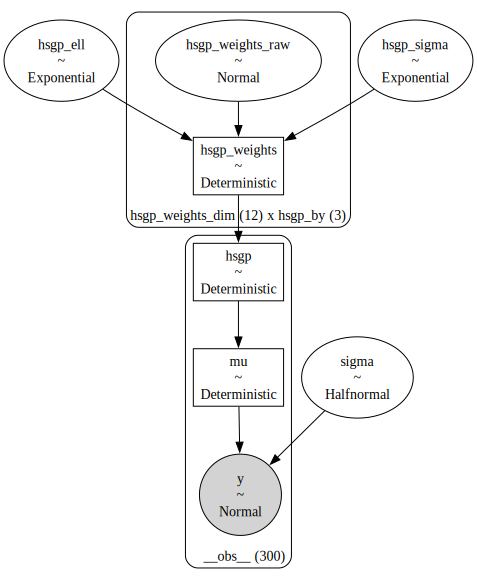

In [17]:
model.build()
model.graph()

See how nicer are the names for the HSGP contribution parameters with the alias!

In [18]:
idata = model.fit(target_accept=0.95, random_seed=121195)
print(idata.sample_stats.diverging.sum().item())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp_sigma, hsgp_ell, hsgp_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


0


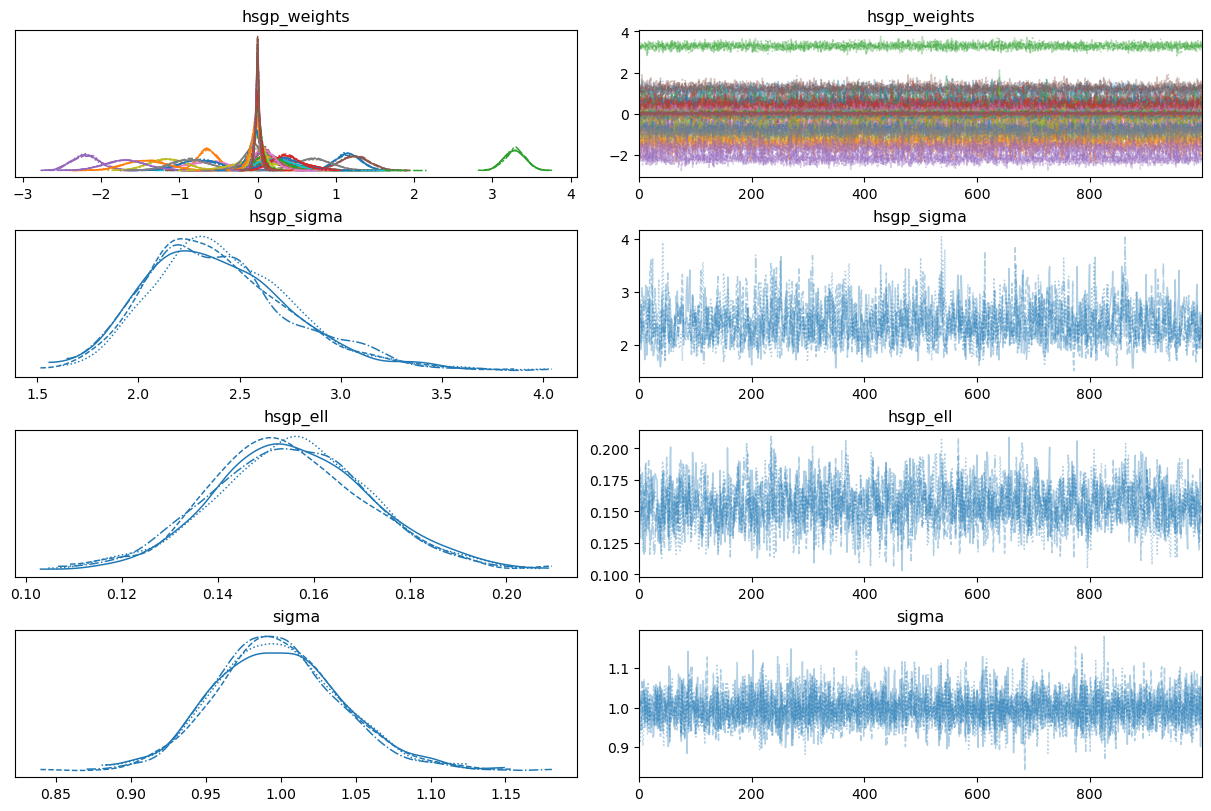

In [19]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "sigma"], 
    backend_kwargs={"layout": "constrained"}
);

This time we got no divergences and good mixing and nice convergence in our first try (or perhaps it wasn't the first try!). One thing that stands out are the marginal posterior for some of the beta parameters (the weights of the basis). This may indicate our approximation is using more basis vectors than what's really needed.

**Note:** At this point we have used the term 'basis vector' several times. This concept is very close to the concept of 'basis functions'. The difference is that the 'basis vector' is a 'basis function' already evaluated at a set of points. In this case, the set of points is made by the values of the numerical predictor `x2`.

Do you remember how easy was it to use `plot_predictions()` above? Should it be harder now? Well, the answer will surprise you: No!

All we need to do is pass a second variable name, which is then mapped to the color in the visualization. Voilà!

Default computed for conditional variable: x2, fac


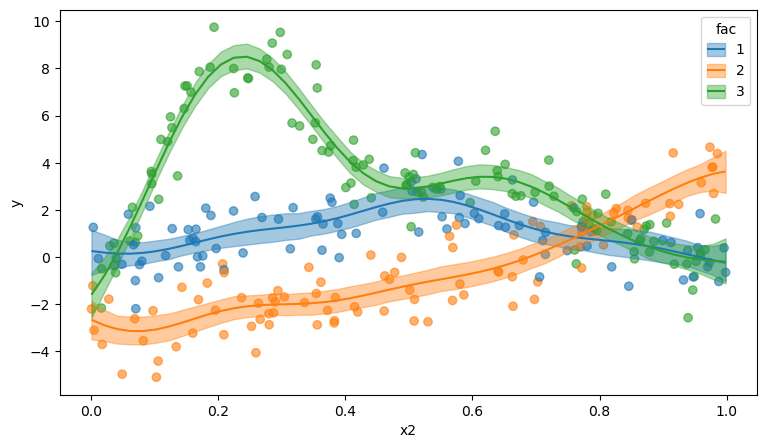

In [20]:
fig, ax = plt.subplots(figsize = (9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
plot_predictions(model, idata, ["x2", "fac"], ax=ax);

We can go one step further and modify the model to use different covariance functions for the different groups. For that purpose, we pass `share_cov=False`. As always, Bambi takes care of all the details.

In [21]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": "hsgp"})
model

       Formula: y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 300
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ Exponential(lam: 3.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)

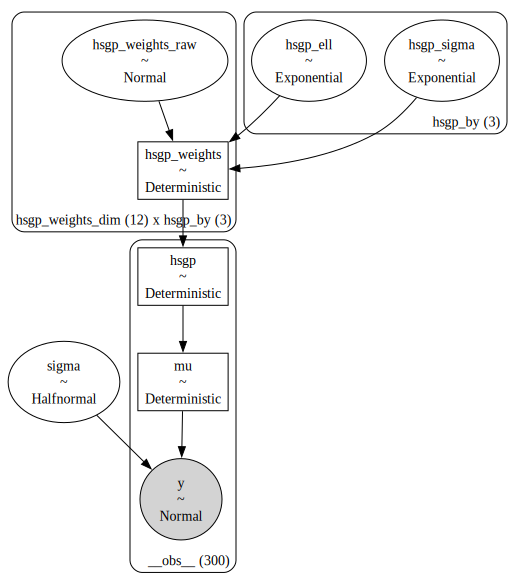

In [22]:
model.build()
model.graph()

Have a closer look at the model graph. See that the `hsgp_sigma` and `hsgp_ell` parameters are no longer scalar. There are three of each, one for each group.

In [23]:
idata = model.fit(target_accept=0.95, random_seed=121195)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp_sigma, hsgp_ell, hsgp_weights_raw]


Output()

/home/tomas/Desktop/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/home/tomas/Desktop/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


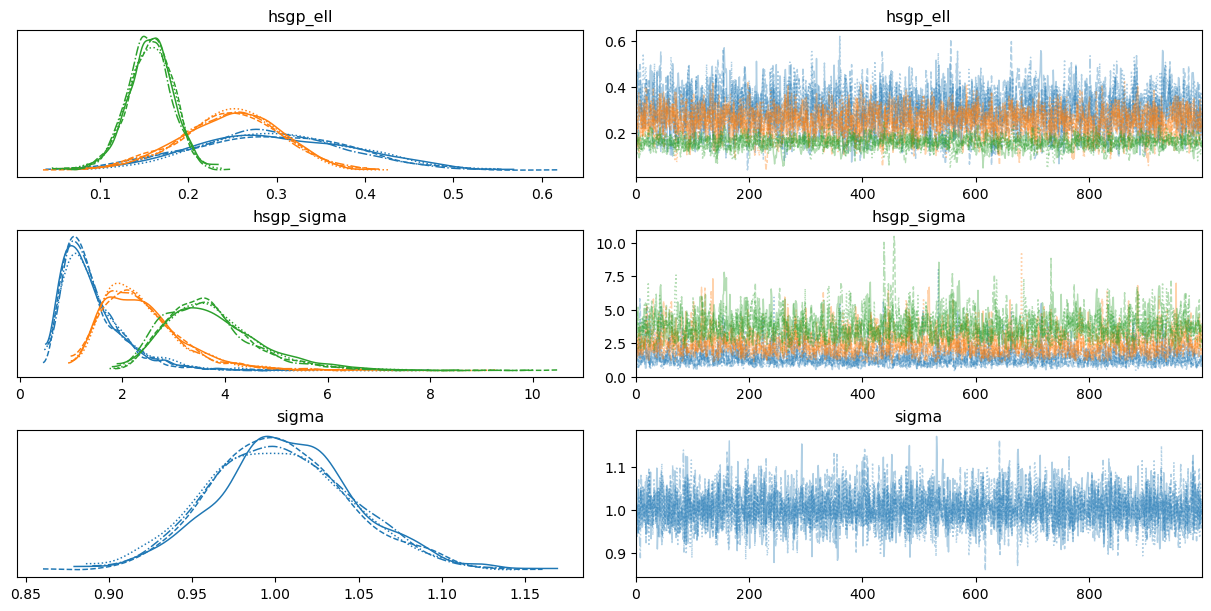

In [24]:
az.plot_trace(
    idata,
    var_names=["hsgp_ell", "hsgp_sigma", "sigma"],
    backend_kwargs={"layout": "constrained"}
);

In fact, we can see not all the groups have similar posteriors for the covariance function parameters when they are allowed to vary.

Before closing the article, it's worth looking at a particular but not uncommon pattern when using the HSGP approximation. Let's have a look at the posterior distributions for the weights of the basis.

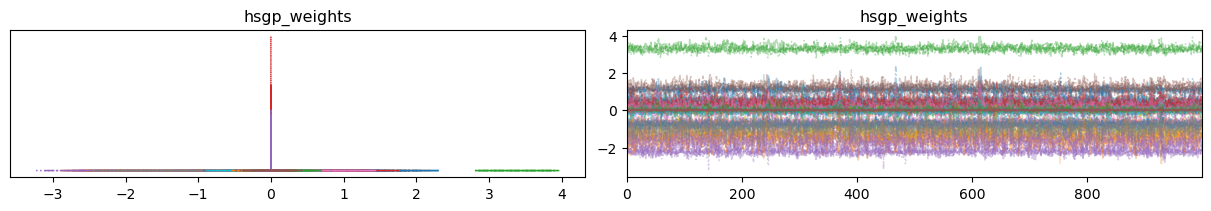

In [25]:
az.plot_trace(idata, var_names=["hsgp_weights"], backend_kwargs={"layout": "constrained"});

Looks like some distributions are extremely flat, and others are extremely tight around zero. 

To investigate this further we can manually plot the posterior for the first J basis vectors and see what they look like.

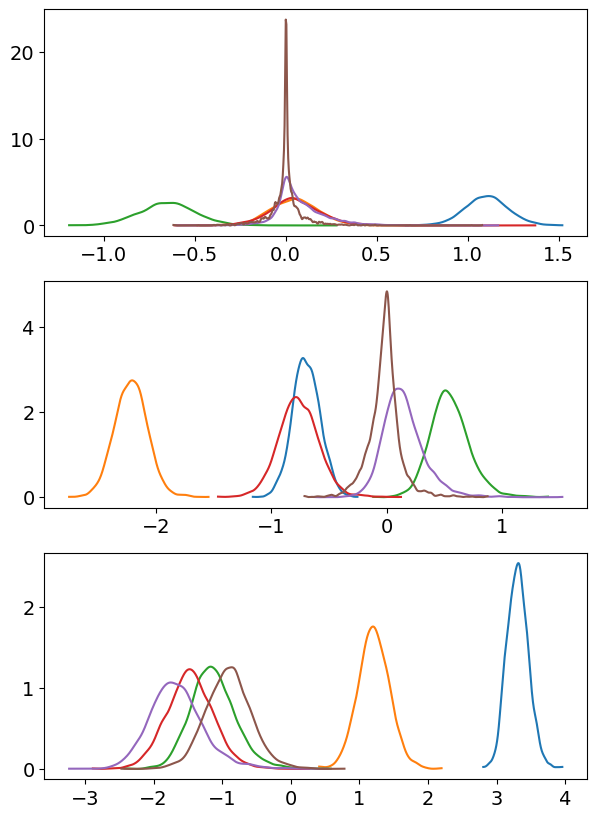

In [26]:
basis_n = 6
fig, axes = plt.subplots(3, 1, figsize = (7, 10))
for i in range(3):
    ax = axes[i]
    values = idata.posterior["hsgp_weights"].sel({"hsgp_by": i + 1})
    for j in range(basis_n):
        az.plot_kde(
            values.sel({"hsgp_weights_dim": j}).to_numpy().flatten(), 
            ax=ax, 
            plot_kwargs={"color": f"C{j}"}
        );

Indeed, we can see that, at least for the first group, the posterior of the weights start being too tight around zero when we consider the 6th basis vector. But the posteriors for the weights of the previous basis vectors look nice. 

To confirm our thought, let's increase the value of `basis_n` to 9 and see what happens.

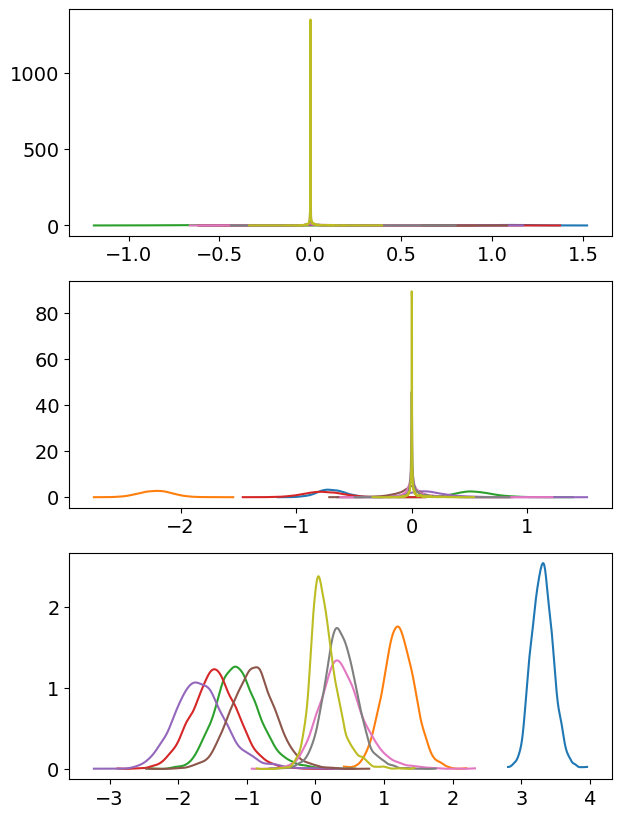

In [27]:
basis_n = 9
fig, axes = plt.subplots(3, 1, figsize = (7, 10))
for i in range(3):
    ax = axes[i]
    values = idata.posterior["hsgp_weights"].sel({"hsgp_by": i + 1})
    for j in range(basis_n):
        az.plot_kde(
            values.sel({"hsgp_weights_dim": j}).to_numpy().flatten(),
            ax=ax,
            plot_kwargs={"color": f"C{j}"}
        );

Alright, that's too spiky! Nonetheless, we don't see that happening for the third group yet, indicating the higher number of basis vectors is more appropriate for this group.

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Dec 16 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.6.0

numpy     : 2.3.3
arviz     : 0.22.0
bambi     : 0.15.1.dev47+g707bbd9e5.d20251216
formulae  : 0.5.5.dev7+g20f109850
pandas    : 2.3.3
matplotlib: 3.10.7

Watermark: 2.5.0

